In [1]:
import glob
import json
import os
from pathlib import Path
import numpy as np
import pandas as pd
from siuba import group_by, summarize, arrange, filter, mutate, if_else, _
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

import torch
from torchvision import transforms
from multimodal.multimodal_lit import MultiModalLitModel
import clip
from sklearn.manifold import TSNE
from PIL import Image

In [2]:
# visualize embeddings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
normalizer = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

preprocess = transforms.Compose([
            transforms.Resize((224, 224),
                              interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            normalizer,
        ])

# load embedding checkpoint
checkpoint_name = f"multimodal_text_encoder_embedding_embedding_dim_512_batch_size_8_dropout_i_0.5_lr_0.0001_lr_scheduler_True_weight_decay_0.1_max_epochs_400_seed_0"
checkpoint = glob.glob(f"/home/wv9/code/WaiKeen/multimodal-baby/checkpoints/{checkpoint_name}/epoch*.ckpt")[0]
model = MultiModalLitModel.load_from_checkpoint(checkpoint, map_location=device)
model.eval()
print("")

In [3]:
# get image embeddings
DATA_DIR = Path("/misc/vlgscratch4/LakeGroup/shared_data/S_multimodal")
EVALUATION_FRAMES_DIR = DATA_DIR / "eval" / "test"
eval_categories = sorted(os.listdir(EVALUATION_FRAMES_DIR))

all_image_features = []
all_eval_categories = []
all_image_filenames = []

for eval_category in eval_categories:
    frames = sorted(glob.glob(os.path.join(EVALUATION_FRAMES_DIR, eval_category, "*.jpeg")))
    print(eval_category, len(frames))
    frames = np.random.choice(frames, size=min(len(frames), 200), replace=False)
    
    for frame in frames:
        I = preprocess(Image.open(frame).convert('RGB')).unsqueeze(0).to(device)
        image_features, _ = model.model.encode_image(I)
        all_image_features.append(image_features.squeeze().detach().cpu().numpy())
        all_eval_categories.append(eval_category)
        
        # rename frame
        frame_path = frame.split(os.path.sep)
        frame = os.path.join(*frame_path[-4:])
        all_image_filenames.append(frame)

ball 2107


/home/wv9/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


basket 74
car 646
cat 752
chair 535
computer 841
crib 460
door 1268
floor 2718
foot 408
ground 1091
hand 1547
kitchen 1080
paper 716
puzzle 1529
road 1741
room 1979
sand 318
stairs 477
table 1324
toy 4307
window 1189


In [4]:
VOCAB_FILENAME = DATA_DIR / "vocab.json"
with open(VOCAB_FILENAME) as f:
    vocab = json.load(f)
    
all_text_features = []
eval_categories[3] = "kitty"  # match eval set-up

for eval_category in eval_categories:
    text = torch.tensor([vocab[eval_category]]).unsqueeze(0).to(device)
    text_len = torch.tensor([len(text)], dtype=torch.long).to(device)
    text_features, _ = model.model.encode_text(text, text_len)
    all_text_features.append(text_features.squeeze().detach().cpu().numpy())

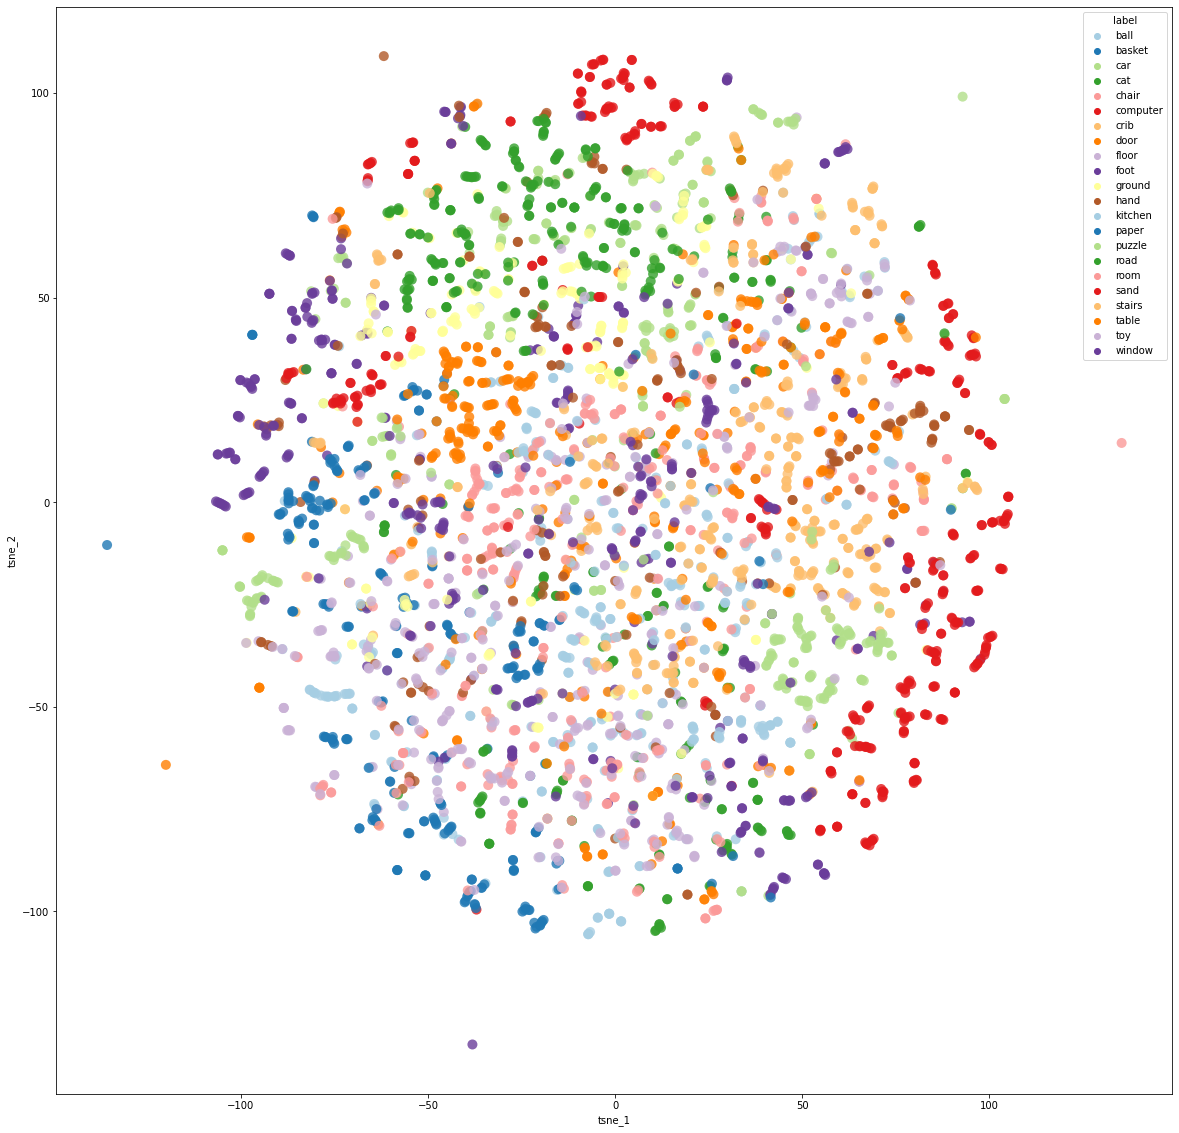

In [18]:
# plot image embeddings
n_components = 2
tsne = TSNE(n_components, perplexity=2)
tsne_result = tsne.fit_transform(all_image_features)
 
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': all_eval_categories, 'filename': all_image_filenames})
fig = plt.figure(figsize=(20, 20))

ax = plt.gca()
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, s=100, legend="auto", palette="Paired", linewidth=0, alpha=0.8)
lim = (tsne_result.min()-5, tsne_result.max()+5)

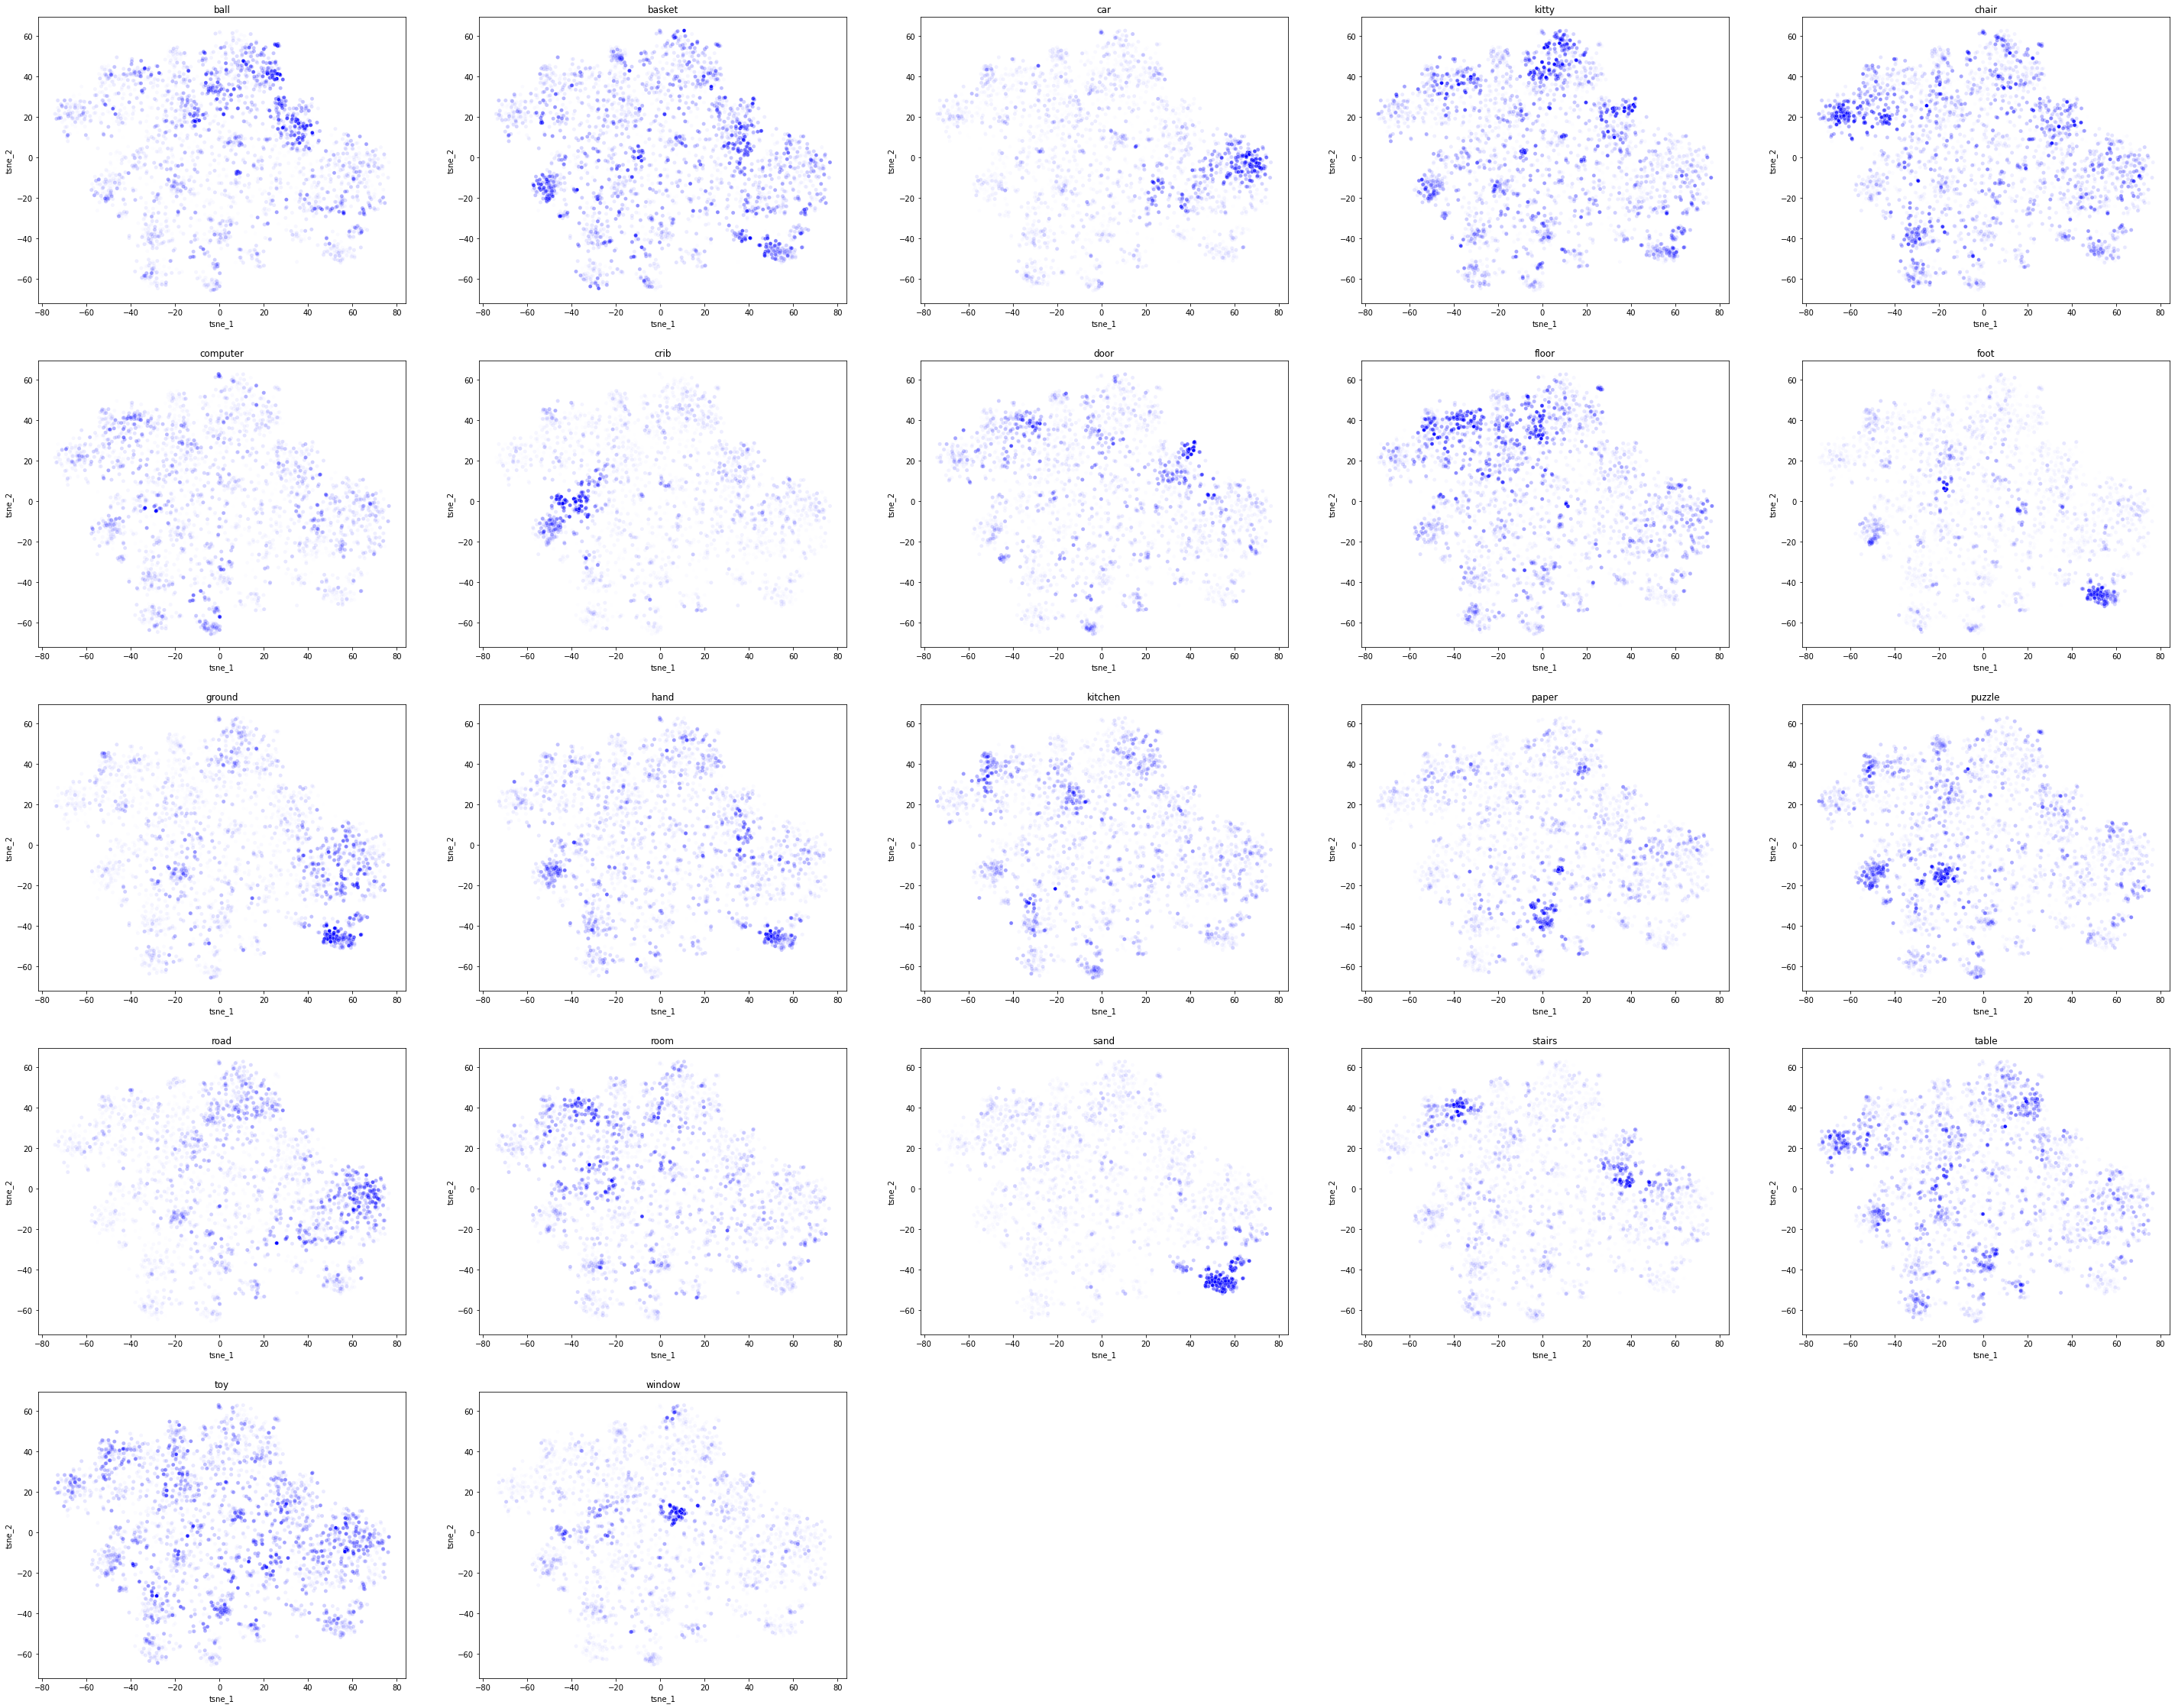

In [15]:
# compute cosine similarities for each eval category
fig = plt.figure(figsize=(50, 40))
for i, curr_category in enumerate(eval_categories):
    category_idx = eval_categories.index(curr_category)
    sims = []
    for image_feature in all_image_features:
        sim = np.power(np.dot(image_feature, all_text_features[category_idx]) / (np.linalg.norm(image_feature)*np.linalg.norm(all_text_features[category_idx])), 2)
        sims.append(sim)

    sims = np.array(sims)
    sims = (sims - np.min(sims))/np.ptp(sims)

    tsne_result_df[curr_category] = sims

    ax = fig.add_subplot(5, 5, i+1)
    ax.set_title(curr_category)
    # ax = plt.gca()
    sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_result_df, s=25, color='blue', legend='full', alpha=sims)
    lim = (tsne_result.min()-5, tsne_result.max()+5)

In [16]:
# save to CSV
tsne_result_df.to_csv("../results/alignment/joint_embeddings_with_eval_sims.csv", index=False)